<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/langchain/langgraph/LangGraph_research_automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Assistant

## Topics

* Memory
* Human-in-the-loop
* Controllability

### research automation.

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection`
* Users can choose any set of input sources for their research.
  
`Planning`
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state.
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format`
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format.

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia langchain-google-genai google-cloud-aiplatform

In [ ]:
!pip install semanticscholar  xmltodict -q

## Setup

In [ ]:
import os, getpass
from google.colab import userdata
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

#_set_env("OPENAI_API_KEY")

In [ ]:
if "GEMINI_API_KEY" not in os.environ:
    os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get('KEY_OPENAI')

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0, max_completion_tokens=8092)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

In [ ]:
#llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-002")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [ ]:
#_set_env("LANGCHAIN_API_KEY")
if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-research"

## Generate Analysts: Human-In-The-Loop

A single shared state makes the process easier to observe, interrupt and modify. Which is very important for complex LLM applications, where some amount of human supervision/approval/editing can be the difference between a toy and a deployment useful in the real world

Create analysts and review them using human-in-the-loop.

https://blog.langchain.dev/human-in-the-loop-with-opengpts-and-langgraph/



In [ ]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

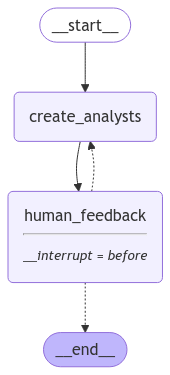

In [62]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [63]:
# Input
max_analysts = 3
topic = "Rare diseases in children"#"Prevention of cardiovascular conditions"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Children's Rare Disease Research Institute
Role: Pediatric Geneticist
Description: Dr. Carter focuses on the genetic underpinnings of rare diseases in children. Her primary concern is identifying genetic markers that can lead to early diagnosis and potential treatment options. She is motivated by the potential to improve patient outcomes through personalized medicine and genetic counseling.
--------------------------------------------------
Name: Mr. John Thompson
Affiliation: National Health Policy Center
Role: Health Policy Analyst
Description: Mr. Thompson analyzes the impact of health policies on the availability and accessibility of treatments for rare diseases in children. His focus is on advocating for policy changes that increase funding for research and support for affected families. He is driven by the need to address disparities in healthcare access and ensure equitable treatment options for all children.
----------------------------------

In [64]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [65]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone with a Pharmaceutical Research background"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd903b-756c-692e-8002-3ff1beff9e37'}}

In [66]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Children's Rare Disease Research Institute
Role: Pediatric Geneticist
Description: Dr. Carter focuses on the genetic underpinnings of rare diseases in children. Her primary concern is identifying genetic markers that can lead to early diagnosis and potential treatment options. She is motivated by the potential to improve patient outcomes through personalized medicine and genetic counseling.
--------------------------------------------------
Name: Mr. John Thompson
Affiliation: National Health Policy Center
Role: Health Policy Analyst
Description: Mr. Thompson analyzes the impact of health policies on the availability and accessibility of treatments for rare diseases in children. His focus is on advocating for policy changes that increase funding for research and support for affected families. He is driven by the need to address disparities in healthcare access and ensure equitable treatment options for all children.
----------------------------------

In [67]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd903c-bf47-675e-8004-d6d5a9c275cf'}}

In [68]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [69]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [70]:
final_state.next

()

In [71]:
final_state.values

{'topic': 'Rare diseases in children',
 'max_analysts': 3,
 'analysts': [Analyst(affiliation="Children's Hospital Research Institute", name='Dr. Emily Carter', role='Pediatric Geneticist', description='Dr. Carter focuses on the genetic underpinnings of rare diseases in children. Her primary concern is understanding how genetic mutations contribute to these diseases and how early genetic screening can lead to better outcomes. She is motivated by the potential to develop targeted therapies that can address the root causes of these conditions.'),
  Analyst(affiliation='Global Health Policy Institute', name='Mr. Raj Patel', role='Health Policy Analyst', description='Mr. Patel examines the policy implications of rare diseases in children, particularly in terms of access to care and funding for research. His concerns include the disparities in healthcare access for children with rare diseases and the need for international collaboration to improve treatment options. He is driven by the goal 

In [72]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Children's Hospital Research Institute
Role: Pediatric Geneticist
Description: Dr. Carter focuses on the genetic underpinnings of rare diseases in children. Her primary concern is understanding how genetic mutations contribute to these diseases and how early genetic screening can lead to better outcomes. She is motivated by the potential to develop targeted therapies that can address the root causes of these conditions.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Global Health Policy Institute
Role: Health Policy Analyst
Description: Mr. Patel examines the policy implications of rare diseases in children, particularly in terms of access to care and funding for research. His concerns include the disparities in healthcare access for children with rare diseases and the need for international collaboration to improve treatment options. He is driven by the goal of influencing policy to ensure equitable healthcare so

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [ ]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [ ]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    print("### Generate Question ####")
    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    print(f"QUESTION: {question.content}")

    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [73]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(f"{var}")

os.environ["TAVILY_API_KEY"]=  userdata.get("TAVILY_API_KEY")

In [74]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [75]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

# Semantic Scholar search tool

The Semantic Scholar REST API allows you to find and explore scientific publication data about authors, papers, citations, venues, and more.


- https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.semanticscholar.SemanticScholarAPIWrapper.html#langchain_community.utilities.semanticscholar.SemanticScholarAPIWrapper

- https://api.semanticscholar.org/api-docs/graph#tag/Paper-Data/operation/get_graph_paper_relevance_search

In [76]:
# Semantic Scholar search tool
from langchain_community.utilities.semanticscholar import SemanticScholarAPIWrapper
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain import hub
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langchain_community.tools.semanticscholar.tool import SemanticScholarQueryRun

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["GOOGLE_CSE_ID"] = userdata.get("GOOGLE_CSE_ID")
os.environ["USER_AGENT"] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
google_scholar = SemanticScholarAPIWrapper(
                    doc_content_chars_max=10000, top_k_results=10
                ) # top_k_results = 3, load_max_docs = 3

In [77]:
google_scholar = SemanticScholarAPIWrapper(
                    top_k_results = 5, load_max_docs = 10
                )

In [78]:
publications = google_scholar.run(topic)

In [79]:
publications

'Published year: 2022\nTitle: A survey of registered pharmacological clinical trials on rare neurological diseases in children in 2010–2020\nAuthors: Xuting Chang, Jie Zhang, Yuwu Jiang, M. Shang, Ye Wu\nAbstract: Objective To clarify the current state of methodology of clinical trials for rare neurological diseases in children, and to provide a basis for the further optimization of the trial design. Methods Data of clinical trials for the rare neurological diseases with childhood onset (searched through https://rarediseases.info.nih.gov/diseases and www.Orpha.net) registered on the Clinicaltrils.gov from January 2010 to June 2020 was collected. Analysis on the methodology of the clinical trials were performed, focusing on initiator of the studies, multi or single research center, study design, sample size, and the endpoint using in the trial. Results A total of 162 clinical trials were included, covering only 7.3% (61/835) of rare neurological diseases in children. 101 (62.3%) were in

In [80]:
from typing import List, Optional
from pydantic import BaseModel, Field
class Output(BaseModel):
    autors: str = Field(description="List of authors of this paper")
    title: str = Field(description="title of this paper")
    abstract: str = Field(description="abstract of this paper")
    url: Optional[str] = Field(description="url of this paper")

class Documents(BaseModel):
    documents: List[Output] = Field(description="List of documents")

query = "rare diseases in children"

# Set up a parser + inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object=Documents)

prompt = PromptTemplate(
    template="Format this text {publications} according to the model.\n{format_instructions}\n",

    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain2 = prompt | llm | parser

docs = chain2.invoke({"publications":publications})

In [81]:
docs


Documents(documents=[Output(autors='Xuting Chang, Jie Zhang, Yuwu Jiang, M. Shang, Ye Wu', title='A survey of registered pharmacological clinical trials on rare neurological diseases in children in 2010–2020', abstract='Objective To clarify the current state of methodology of clinical trials for rare neurological diseases in children, and to provide a basis for the further optimization of the trial design. Methods Data of clinical trials for the rare neurological diseases with childhood onset (searched through https://rarediseases.info.nih.gov/diseases and www.Orpha.net) registered on the Clinicaltrils.gov from January 2010 to June 2020 was collected. Analysis on the methodology of the clinical trials were performed, focusing on initiator of the studies, multi or single research center, study design, sample size, and the endpoint using in the trial. Results A total of 162 clinical trials were included, covering only 7.3% (61/835) of rare neurological diseases in children. 101 (62.3%) w

In [82]:
for doc in docs.documents:
  print(f"Author: {doc.autors}")
  print(f"Title: {doc.title}")
  print(f"Abstract: {doc.abstract}")
  print(f"URL: {doc.url}")
  print("-"*50)

Author: Xuting Chang, Jie Zhang, Yuwu Jiang, M. Shang, Ye Wu
Title: A survey of registered pharmacological clinical trials on rare neurological diseases in children in 2010–2020
Abstract: Objective To clarify the current state of methodology of clinical trials for rare neurological diseases in children, and to provide a basis for the further optimization of the trial design. Methods Data of clinical trials for the rare neurological diseases with childhood onset (searched through https://rarediseases.info.nih.gov/diseases and www.Orpha.net) registered on the Clinicaltrils.gov from January 2010 to June 2020 was collected. Analysis on the methodology of the clinical trials were performed, focusing on initiator of the studies, multi or single research center, study design, sample size, and the endpoint using in the trial. Results A total of 162 clinical trials were included, covering only 7.3% (61/835) of rare neurological diseases in children. 101 (62.3%) were initiated by pharmaceutical 

In [83]:
i = 0
docums= []
for item in docs.documents:


  doc = f'<Document source="{item.title}"\n Abstract="{item.abstract}",\n authors: {item.autors}\n</Document>'
  docums.append(doc)

text = "\n\n---\n\n".join(
        [

           str(doc) for doc in docums
        ]
 )
print(text)

<Document source="A survey of registered pharmacological clinical trials on rare neurological diseases in children in 2010–2020"
 Abstract="Objective To clarify the current state of methodology of clinical trials for rare neurological diseases in children, and to provide a basis for the further optimization of the trial design. Methods Data of clinical trials for the rare neurological diseases with childhood onset (searched through https://rarediseases.info.nih.gov/diseases and www.Orpha.net) registered on the Clinicaltrils.gov from January 2010 to June 2020 was collected. Analysis on the methodology of the clinical trials were performed, focusing on initiator of the studies, multi or single research center, study design, sample size, and the endpoint using in the trial. Results A total of 162 clinical trials were included, covering only 7.3% (61/835) of rare neurological diseases in children. 101 (62.3%) were initiated by pharmaceutical companies, and 61 (37.7%) by investigators. Most

# SemanticScholarQueryRun

https://python.langchain.com/docs/integrations/tools/semanticscholar/

In [84]:
instructions = """You are an expert researcher. provide title , abstract and authors of the documents you use to provide an answer"""
base_prompt = hub.pull("langchain-ai/openai-functions-template")
prompt = base_prompt.partial(instructions=instructions)

In [85]:
from langchain_community.tools.semanticscholar.tool import SemanticScholarQueryRun

tools = [SemanticScholarQueryRun()]
agent = create_openai_functions_agent(llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    return_intermediate_steps=True,
)

In [86]:
documents = agent_executor.invoke(
    {
        "input": topic
    }
)



> Entering new AgentExecutor chain...

Invoking: `semanticscholar` with `{'query': 'Rare diseases in children'}`


Published year: 2022
Title: A survey of registered pharmacological clinical trials on rare neurological diseases in children in 2010–2020
Authors: Xuting Chang, Jie Zhang, Yuwu Jiang, M. Shang, Ye Wu
Abstract: Objective To clarify the current state of methodology of clinical trials for rare neurological diseases in children, and to provide a basis for the further optimization of the trial design. Methods Data of clinical trials for the rare neurological diseases with childhood onset (searched through https://rarediseases.info.nih.gov/diseases and www.Orpha.net) registered on the Clinicaltrils.gov from January 2010 to June 2020 was collected. Analysis on the methodology of the clinical trials were performed, focusing on initiator of the studies, multi or single research center, study design, sample size, and the endpoint using in the trial. Results A total of 162 clinical

In [87]:
documents.keys()

dict_keys(['input', 'output', 'intermediate_steps'])

In [88]:
print(documents['output'])

Here are two research papers related to rare diseases in children:

1. **Title**: A survey of registered pharmacological clinical trials on rare neurological diseases in children in 2010–2020  
   **Authors**: Xuting Chang, Jie Zhang, Yuwu Jiang, M. Shang, Ye Wu  
   **Abstract**: This study aims to clarify the current state of clinical trial methodologies for rare neurological diseases in children and provide a basis for optimizing trial design. It analyzes data from clinical trials registered between 2010 and 2020, focusing on study initiators, design, sample size, and endpoints. The study found that few clinical trials target rare neurological diseases in children, with most trials initiated by pharmaceutical companies and involving fewer participants. The study suggests the need for global multicenter recruitment and optimal study designs to improve evidence levels in clinical trials for rare diseases.

2. **Title**: An Analysis of Medical Care Services for Children With Rare Disea

In [89]:
print(documents['intermediate_steps'])

[(AgentActionMessageLog(tool='semanticscholar', tool_input={'query': 'Rare diseases in children'}, log="\nInvoking: `semanticscholar` with `{'query': 'Rare diseases in children'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"query":"Rare diseases in children"}', 'name': 'semanticscholar'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4'}, id='run-cb4501d6-0e7e-4ca0-9fc2-a27752b8bd5f')]), 'Published year: 2022\nTitle: A survey of registered pharmacological clinical trials on rare neurological diseases in children in 2010–2020\nAuthors: Xuting Chang, Jie Zhang, Yuwu Jiang, M. Shang, Ye Wu\nAbstract: Objective To clarify the current state of methodology of clinical trials for rare neurological diseases in children, and to provide a basis for the further optimization of the trial design. Methods Data of clinical trials for the rare neurological diseases wit

# Using Semantic Sholar Library


https://api.semanticscholar.org/api-docs/graph#tag/Paper-Data/operation/get_graph_paper_relevance_search


https://github.com/danielnsilva/semanticscholar


In [90]:
from semanticscholar import SemanticScholar
sch = SemanticScholar()
results = sch.search_paper('Rare diseases in children', fields_of_study=['Medicine'], limit=10) #, fields=['title','year'])



In [91]:
i = 0
docs= []
for item in results:

  autor_names = "".join(f"{autor.name}, " for autor in item.authors )
  doc = f'<Document source="{item.url}" page="{item.title}"/>\n{item.abstract}, authors: {autor_names}\n</Document>'
  docs.append(doc)
  i=i+1
  if i > 10:
    break


In [92]:
"\n\n---\n\n".join(
        [

           str(doc) for doc in docs
        ]
 )

'<Document source="https://www.semanticscholar.org/paper/d2964573b4e8f5bf5a04e05c48791d1e8da5000e" page="A survey of registered pharmacological clinical trials on rare neurological diseases in children in 2010–2020"/>\nObjective To clarify the current state of methodology of clinical trials for rare neurological diseases in children, and to provide a basis for the further optimization of the trial design. Methods Data of clinical trials for the rare neurological diseases with childhood onset (searched through https://rarediseases.info.nih.gov/diseases and www.Orpha.net) registered on the Clinicaltrils.gov from January 2010 to June 2020 was collected. Analysis on the methodology of the clinical trials were performed, focusing on initiator of the studies, multi or single research center, study design, sample size, and the endpoint using in the trial. Results A total of 162 clinical trials were included, covering only 7.3% (61/835) of rare neurological diseases in children. 101 (62.3%) we

# Pubmed
PubMed® comprises more than 37 million citations for biomedical literature from MEDLINE, life science journals, and online books. Citations may include links to full text content from PubMed Central and publisher web sites.

- https://python.langchain.com/api_reference/community/retrievers/langchain_community.retrievers.pubmed.PubMedRetriever.html

- https://www.ncbi.nlm.nih.gov/

In [93]:
from langchain_community.retrievers import PubMedRetriever

In [94]:
from google.colab import userdata
pubmed_key =userdata.get('PUBMED_KEY')

In [95]:
retriever = PubMedRetriever(api_key=pubmed_key, top_k_results=5 )

In [96]:
pubmed_docs = retriever.invoke(topic)

In [97]:
len(pubmed_docs)

5

In [98]:
for doc in pubmed_docs:
  print(doc.page_content)
  print(doc.metadata)
  print("-"*50)

Pediatric cholestatic liver diseases are rare conditions that can result from multiple specific underlying etiologies. Among the most common etiologies of pediatric cholestatic liver diseases are biliary atresia, Alagille syndrome (ALGS), and inherited disorders of bile acid transport. These diseases are characterized by episodic or chronic unremitting cholestasis. Due to the chronicity of these conditions, it is imperative to optimize medical management to improve patient quality of life, provide nutritional support, and reduce bile acid toxicity in efforts to slow disease progression. Cholestatic liver diseases remain the leading cause of pediatric liver transplantation, as many underlying disease etiologies have no curative medical therapies. In the present review, we provide an update on the nutritional, medical, and surgical management of pediatric cholestatic liver diseases. As recent advances have occurred in the field with the addition of ileal bile acid transporter (IBAT) inhi

In [99]:
doc.metadata

{'uid': '39840303',
 'Title': 'The Labial Adhesion in Postmenopausal Women: A Systematic Review.',
 'Published': '2024-12-01',
 'Copyright Information': 'Copyright: © Iranian Journal of Medical Sciences.'}

In [100]:
docs_pubmed= []
for item in pubmed_docs:


  doc = f'<Document source Pubmed="{item.metadata.get("uid")}" \n Title :"{item.metadata.get("Title")}"/>\n, Abstract: {item.page_content}\n</Document>'
  docs_pubmed.append(doc)



In [101]:
texto = "\n\n---\n\n".join(
        [

           str(doc) for doc in docs_pubmed
        ]
 )

print(texto)

<Document source Pubmed="39840645" 
 Title :"Recent advances in the management of pediatric cholestatic liver diseases."/>
, Abstract: Pediatric cholestatic liver diseases are rare conditions that can result from multiple specific underlying etiologies. Among the most common etiologies of pediatric cholestatic liver diseases are biliary atresia, Alagille syndrome (ALGS), and inherited disorders of bile acid transport. These diseases are characterized by episodic or chronic unremitting cholestasis. Due to the chronicity of these conditions, it is imperative to optimize medical management to improve patient quality of life, provide nutritional support, and reduce bile acid toxicity in efforts to slow disease progression. Cholestatic liver diseases remain the leading cause of pediatric liver transplantation, as many underlying disease etiologies have no curative medical therapies. In the present review, we provide an update on the nutritional, medical, and surgical management of pediatric

Now, we create nodes to search the web and wikipedia and Semantic Scholar

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

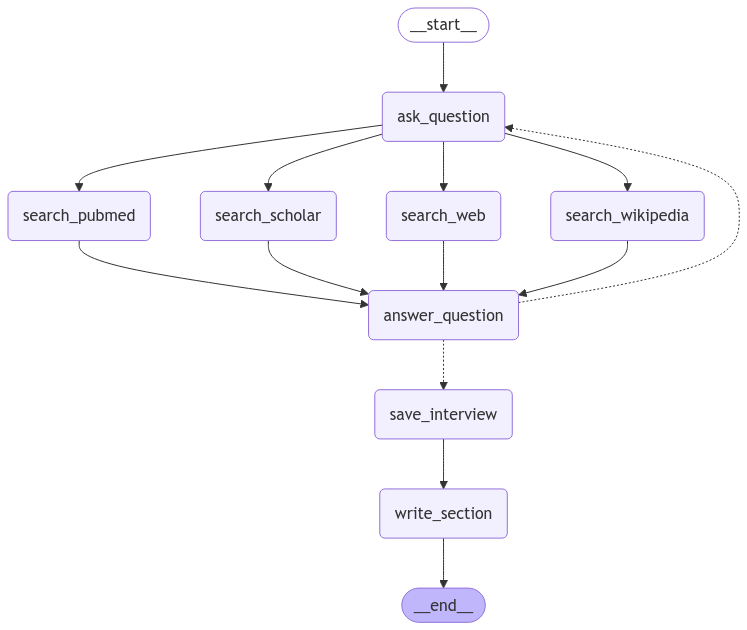

In [102]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    print("### Search Tavili ####")
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    print("### Search Wikipedia ####")
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_scholar(state: InterviewState):

    """ Retrieve docs from scholar """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    results = google_scholar.run(search_query.search_query)

    print("### Search Semantic Scholar ####")
    docs = chain2.invoke({"publications":results})

    docums= []
    for item in docs.documents:


      doc = f'<Document source="{item.title}"\n Abstract="{item.abstract}",\n authors: {item.autors}\n</Document>'
      docums.append(doc)

    text = "\n\n---\n\n".join(
            [

              str(doc) for doc in docums
            ]
    )

    return {"context": [text]}

def search_pubmed(state: InterviewState):

    """ Retrieve docs from pubmed """
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    print("### Search Pubmed ####")
    pubmed_docs = retriever.invoke(search_query.search_query)
    docs_pubmed= []
    for item in pubmed_docs:
      doc = f'<Document source Pubmed="{item.metadata.get("uid")}" \n Title :"{item.metadata.get("Title")}"/>\n, Abstract: {item.page_content}\n</Document>'
      docs_pubmed.append(doc)

    texto = "\n\n---\n\n".join(
      [

          str(doc) for doc in docs_pubmed
      ]
    )
    return {"context": [texto]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

skip the addition of the brackets as well as the Document source preamble in your citation.

add authors of the documents if possible"""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    print("### Generate Answer ####")
    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)
    print("### Routing Messages ####")
    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)



4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- link the Sources to the authors and titles of the documents.
- It will look like:

### Sources
[1] Link or Document name, Authors
[2] Link or Document name, Authors

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    print("### Writting Section ####")
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("search_scholar", search_scholar)
interview_builder.add_node("search_pubmed", search_pubmed)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("ask_question", "search_scholar")
interview_builder.add_edge("ask_question", "search_pubmed")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_edge("search_scholar", "answer_question")
interview_builder.add_edge("search_pubmed", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [104]:
# Pick one analyst
analysts[2]

Analyst(affiliation='PharmaGen Research Labs', name='Dr. Lisa Nguyen', role='Pharmaceutical Research Scientist', description='Dr. Nguyen is involved in the development of new drugs for rare pediatric diseases. Her focus is on the challenges of creating effective treatments given the small patient populations and the high costs associated with drug development. She is motivated by the potential to bring innovative therapies to market that can significantly improve the quality of life for affected children.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [105]:
topic

'Rare diseases in children'

In [106]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[2], "messages": messages, "max_num_turns": 3}, thread)
Markdown(interview['sections'][0])

### Generate Question ####
QUESTION: Hello, my name is Alex Thompson, and I'm an analyst researching the development of new drugs for rare pediatric diseases. I'm particularly interested in understanding the challenges and innovative approaches in this field. Dr. Nguyen, could you share some specific challenges you face when developing treatments for rare pediatric diseases?
### Search Tavili ####
### Search Wikipedia ####
### Search Pubmed ####
### Search Semantic Scholar ####
### Generate Answer ####
### Routing Messages ####
### Generate Question ####
QUESTION: Thank you for sharing those insights, Dr. Nguyen. Could you provide a specific example of a rare pediatric disease you've worked on and how you approached these challenges in its drug development?
### Search Tavili ####
### Search Pubmed ####
### Search Wikipedia ####
### Search Semantic Scholar ####
### Generate Answer ####
### Routing Messages ####
### Generate Question ####
QUESTION: That's fascinating, Dr. Nguyen. Could y

## Overcoming Challenges in Developing Therapies for Rare Pediatric Diseases

### Summary

The development of new drugs for rare pediatric diseases presents unique challenges due to the small patient populations and high costs associated with drug development. These challenges are compounded by the need for innovative therapies that can significantly improve the quality of life for affected children. Dr. Nguyen's work focuses on addressing these challenges and bringing effective treatments to market.

Rare pediatric diseases often lack sufficient patient populations to conduct robust clinical trials, making it difficult to gather the necessary data for drug approval. This scarcity of data can hinder the development of effective treatments and delay the introduction of potentially life-saving therapies. Additionally, the high costs associated with drug development for rare diseases can deter pharmaceutical companies from investing in research and development, further limiting treatment options for patients [1].

One novel approach to overcoming these challenges is the use of drug repurposing, which involves finding new therapeutic uses for existing drugs. This strategy can accelerate the availability of treatments by leveraging known safety profiles and reducing development costs. Drug repurposing has shown promise in treating conditions like neuroblastoma, a challenging pediatric malignancy with limited treatment options [2]. By repurposing existing drugs, researchers can bring effective therapies to market more quickly, improving patient outcomes and quality of life.

Another innovative strategy is the use of international data partnerships to share information and resources across borders. The International Childhood Cancer Data Partnership, for example, aims to combine data from multiple countries to address complex challenges in pediatric cancer research. This collaborative effort can help answer research questions that would be difficult to tackle with limited data from individual countries [3].

Despite these promising approaches, significant challenges remain. The transition of children with rare diseases from pediatric to adult care is one such challenge, as it requires careful coordination and planning to ensure continuity of care. The lack of standardized recommendations and protocols for this transition can lead to gaps in treatment and care, potentially impacting patient outcomes [4].

In conclusion, the development of therapies for rare pediatric diseases requires innovative approaches and collaborative efforts to overcome the inherent challenges. By leveraging strategies like drug repurposing and international data partnerships, researchers can accelerate the development of effective treatments and improve the quality of life for children affected by these conditions.

### Sources
[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10143853/  
[2] Pubmed: 39258785, "Advances in the approaches used to repurpose drugs for neuroblastoma."  
[3] Pubmed: 39799506, "Making the Case for an International Childhood Cancer Data Partnership."  
[4] "The transition of children with rare diseases from pediatric to adult care", M. Molnár, Judit Cs Sági, L. Szabó, Z. Grosz

### Parallelze interviews: Map-Reduce
Map-reduce operations are essential for efficient task decomposition and parallel processing. This approach involves breaking a task into smaller sub-tasks, processing each sub-task in parallel, and aggregating the results across all of the completed sub-tasks.


https://langchain-ai.github.io/langgraph/how-tos/map-reduce/



We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.
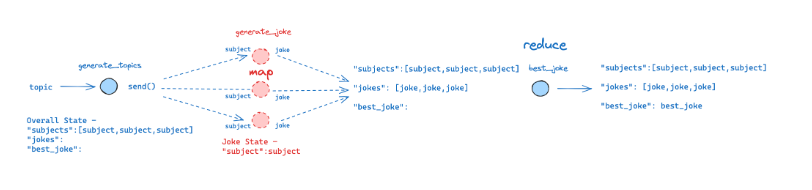
### Finalize

We add a final step to write an intro and conclusion to the final report.

In [ ]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

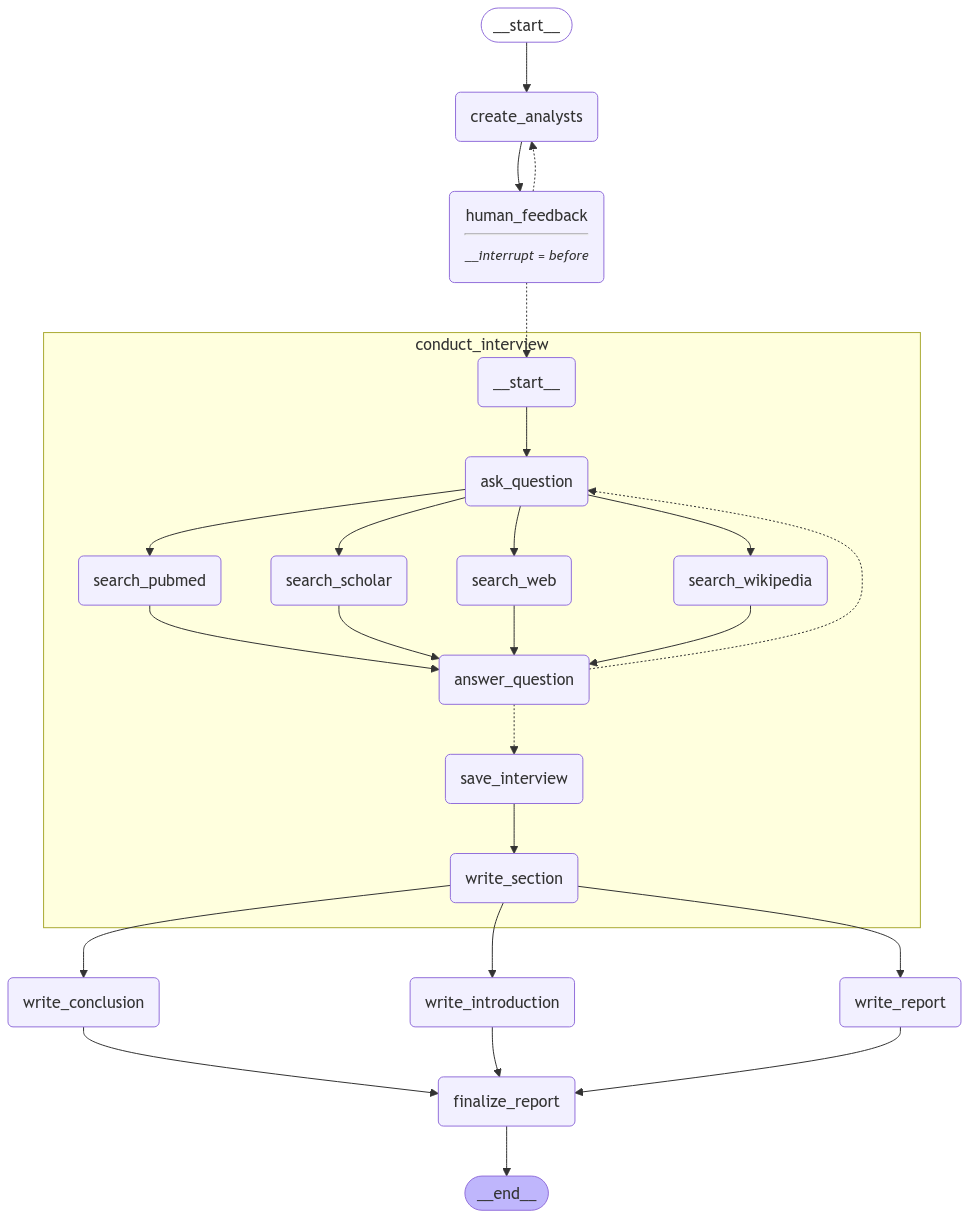

In [107]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    print("### INITIATE ALL INTERVIEWS ####")
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources and authors in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]
    print("### WRITE REPORT ####")
    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]
    print("### WRITE INTRODUCTION ####")
    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]
    print("### WRITE CONCLUSION ####")
    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    print("### FINALIZE REPORT ####")
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [108]:
# Inputs
max_analysts = 4
#topic = "The benefits of adopting a healthy life style to prevent cardiovascular conditions"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Children's Rare Disease Research Institute
Role: Pediatric Geneticist
Description: Dr. Carter focuses on the genetic underpinnings of rare diseases in children. Her primary concern is identifying genetic markers that can lead to early diagnosis and potential gene therapies. She is motivated by the potential to improve early intervention strategies and enhance the quality of life for affected children.
--------------------------------------------------
Name: Mr. John Thompson
Affiliation: National Health Policy Center
Role: Health Policy Analyst
Description: Mr. Thompson analyzes the impact of health policies on the availability and accessibility of treatments for rare diseases in children. He is concerned with policy gaps that may hinder research funding and access to care. His motive is to advocate for policies that support comprehensive care and research funding for rare pediatric diseases.
--------------------------------------------------
Name: D

In [109]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add somebody with Pharmaceutical reasearch Background   "}, as_node="human_feedback")

### INITIATE ALL INTERVIEWS ####


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9098-7602-6e63-8002-0ca76c8e39cc'}}

In [110]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Children's Rare Disease Research Institute
Role: Pediatric Geneticist
Description: Dr. Carter focuses on the genetic underpinnings of rare diseases in children. Her primary concern is identifying genetic markers that can lead to early diagnosis and potential gene therapies. She is motivated by the potential to improve early intervention strategies and enhance the quality of life for affected children.
--------------------------------------------------
Name: Mr. John Thompson
Affiliation: National Health Policy Center
Role: Health Policy Analyst
Description: Mr. Thompson analyzes the impact of health policies on the availability and accessibility of treatments for rare diseases in children. He is concerned with policy gaps that may hinder research funding and access to care. His motive is to advocate for policies that support comprehensive care and research funding for rare pediatric diseases.
--------------------------------------------------
Name: D

In [111]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

### INITIATE ALL INTERVIEWS ####


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9099-b1be-6122-8004-48e4aa48a1ae'}}

In [112]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

### Generate Question ####
### Generate Question ####
### Generate Question ####
### Generate Question ####
QUESTION: Hello, my name is Emily Carter, and I'm a health journalist focusing on pediatric health issues. I'm particularly interested in the work you're doing on rare diseases in children. Could you share some insights into how you identify patterns in the prevalence of these diseases? Are there any surprising trends you've discovered in your research?
QUESTION: Hello, I'm Alex Thompson, a science journalist focusing on medical advancements. I'm thrilled to have the opportunity to speak with you, Dr. Carter. To start, could you share an example of a rare disease in children where identifying genetic markers has significantly improved early diagnosis and intervention?
QUESTION: Hello, I'm Alex Carter, a health and science journalist. I'm currently working on an article about rare pediatric diseases and the innovative treatments being developed to address them. Dr. Lee, could you 

In [113]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Unraveling the Complexities of Rare Pediatric Diseases

## Introduction

Rare diseases in children present a unique set of challenges, demanding early diagnosis and intervention to improve patient outcomes. This report delves into the genetic intricacies of these conditions, highlighting Dr. Carter's work on genetic markers and early testing. It explores groundbreaking studies, such as those in Saudi Arabia, that reveal novel genetic variants and underscore the importance of early intervention. Dr. Patel's research further illuminates the role of genetic and environmental factors, while Dr. Thompson advocates for equitable healthcare access. Finally, innovative therapies and personalized medicine offer new hope, bridging gaps in treatment and care for affected children.

---



The landscape of rare diseases in children is marked by complex genetic underpinnings, unique challenges in diagnosis and treatment, and significant disparities in healthcare access. Recent advancements in genetic research and personalized medicine offer promising avenues for early diagnosis and intervention, which are crucial for improving patient outcomes. Genetic testing, such as whole exome and genome sequencing, has revolutionized the diagnostic process by identifying pathogenic variants and informing personalized treatment plans [1][5]. Early intervention is pivotal, as it reduces the time to diagnosis and enables more effective treatment strategies, ultimately improving the quality of life for affected children [3][4].

Research highlights the significant role of genetic factors in the manifestation of rare diseases, with approximately 80% of these conditions having genetic origins and half manifesting in childhood [2]. Studies, such as those conducted in Saudi Arabia, have expanded the spectrum of known genetic variants, underscoring the importance of genetic screening in early diagnosis [1]. Additionally, the interaction between genetic predispositions and environmental factors plays a crucial role in disease manifestation, necessitating comprehensive treatment plans that consider both influences [4].

The development of innovative therapies is a critical area of research, driven by the need to address unmet medical needs. Personalized medicine, guided by genetic testing, has enabled the development of targeted therapies, such as vosoritide for achondroplasia, improving treatment efficacy and minimizing side effects [1]. Innovative clinical trial designs are essential for accommodating small patient populations, accelerating the approval of new therapies, and ensuring timely access for patients [2].

Advocacy and policy development are vital in addressing the disparities in healthcare access and outcomes for children with rare diseases. Global inequalities, such as those seen in the treatment of spinal muscular atrophy, highlight the need for international collaboration and policy reform to ensure equitable access to life-saving therapies [1]. The integration of genomics into healthcare, as demonstrated by initiatives like the Australian Genomics program, offers promising advancements for rare disease diagnosis and treatment [3].

The transition from pediatric to adult care poses additional challenges, requiring coordinated efforts to ensure seamless care and support for patients as they age [3]. Public health policies and regulatory frameworks play a crucial role in facilitating drug development for rare pediatric diseases, with recent efforts focusing on patient-centered outcomes and increased patient engagement in clinical trials [4].

In conclusion, the insights gathered from recent studies and expert opinions emphasize the importance of genetic testing, early intervention, innovative therapies, and comprehensive advocacy in managing rare pediatric diseases. By addressing these challenges, the scientific and medical communities can work towards improving outcomes and quality of life for children with rare diseases.


---

## Conclusion

This report underscores the critical importance of early diagnosis and intervention in managing rare pediatric diseases, as highlighted by Dr. Carter's research on genetic markers. The studies from Saudi Arabia and other regions emphasize the role of genetic testing in identifying novel variants, which is crucial for timely intervention. Dr. Patel's work further illuminates the genetic and environmental factors influencing these diseases, advocating for genetic counseling and comprehensive healthcare strategies. Dr. Thompson's advocacy highlights the disparities in access to care and the need for policy reform. Finally, advancements in innovative therapies and personalized medicine offer hope for improved outcomes, bridging gaps in treatment and care for affected children.

## Sources

[1] Monogenic interferon-mediated diseases: novel phenotype and genotype characteristics from a Saudi population, Alhanouf Al-Saleem, Shahad A. Alansari, Mohammed Almuhaizea, Sulaiman M Al-Mayouf  
[2] Intractable and rare diseases research, W. Tang, M. Makuuchi  
[3] https://www.tgen.org/patients/center-for-rare-childhood-disorders/stories/early-intervention-is-crucial-for-better-outcomes-for-children-with-rare-diseases/  
[4] https://fdna.com/health/resource-center/rare-genetic-syndromes-and-their-impact-on-child-development/  
[5] https://www.nature.com/articles/s41390-024-03728-w  
[6] Whole-genome sequencing reveals contribution of rare and common variation to structural kidney and urinary tract malformations, M. Chan, O. Sadeghi-Alavijeh, C. Voinescu, et al.  
[7] Evaluating Anaemia Treatment in Associated Diseases in Children in Port Harcourt, Nigeria, Chijioke-Nwauche In, Origbo Cc  
[8] https://fdna.com/health/resource-center/the-5-most-common-rare-diseases-in-children/  
[9] https://pmc.ncbi.nlm.nih.gov/articles/PMC3647367/  
[10] Pubmed: Life-Saving Treatments for Spinal Muscular Atrophy: Global Access and Availability.  
[11] Pubmed: The psychosocial impact of childhood dementia on children and their parents: a systematic review.  
[12] Pubmed: Australian Genomics: Outcomes of a 5-year national program to accelerate the integration of genomics in healthcare.  
[13] Pubmed: Global burden of 288 causes of death and life expectancy decomposition in 204 countries and territories and 811 subnational locations, 1990-2021: a systematic analysis for the Global Burden of Disease Study 2021.  
[14] "Consensus Guidelines for the Use of Vosoritide in Children with Achondroplasia in Australia," Pubmed.  
[15] "Innovative strategies for trial design," Authors: B. Feldman.  
[16] "[The transition of children with rare diseases from pediatric to adult care]," Authors: M. Molnár, Judit Cs Sági, L. Szabó, Z. Grosz.  
[17] "Development of Medicines for Rare Pediatric Diseases - PMC," https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10143853/.